# Sentiment Analysis

In [1]:
# import all libraries for Sentiment Analysis for Indonesian Language
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk
import matplotlib.pyplot as plt
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

## Load Dataset

In [4]:
# load tsv dataset
df = pd.read_csv('merged_train_valid_file.tsv', sep='\t')

In [5]:
df

,text,label
0,tidak enak,negative
1,restoran ini menawarkan makanan sunda . kami m...,positive
2,lokasi di alun alun masakan padang ini cukup t...,positive
3,betapa bejad kader gerindra yang anggota dprd ...,negative
4,kampiun bistro berada di jalan . kebon kawung ...,positive
...,...,...
12253,tidak kecewa,positive
12254,enak rasa masakan nya apalagi kepiting yang me...,positive
12255,hormati partai-partai yang telah berkoalisi,neutral
12256,"pagi pagi di tol pasteur sudah macet parah , b...",negative


## Preprocessing

### 1. Encode Labels

In [6]:
# print unique label
print(df['label'].unique())

['negative' 'positive' 'neutral']


In [12]:
df_processed = df.copy()
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Encode the labels
df_processed['label encode'] = label_encoder.fit_transform(df_processed['label'])
df_processed


,text,label,label encode
0,tidak enak,negative,0
1,restoran ini menawarkan makanan sunda . kami m...,positive,2
2,lokasi di alun alun masakan padang ini cukup t...,positive,2
3,betapa bejad kader gerindra yang anggota dprd ...,negative,0
4,kampiun bistro berada di jalan . kebon kawung ...,positive,2
...,...,...,...
12253,tidak kecewa,positive,2
12254,enak rasa masakan nya apalagi kepiting yang me...,positive,2
12255,hormati partai-partai yang telah berkoalisi,neutral,1
12256,"pagi pagi di tol pasteur sudah macet parah , b...",negative,0


In [13]:

# Convert the encoded labels to categorical
df_processed['label encode'] = tf.keras.utils.to_categorical(df_processed['label encode'])

In [14]:
df_processed

,text,label,label encode
0,tidak enak,negative,1.0
1,restoran ini menawarkan makanan sunda . kami m...,positive,0.0
2,lokasi di alun alun masakan padang ini cukup t...,positive,0.0
3,betapa bejad kader gerindra yang anggota dprd ...,negative,1.0
4,kampiun bistro berada di jalan . kebon kawung ...,positive,0.0
...,...,...,...
12253,tidak kecewa,positive,0.0
12254,enak rasa masakan nya apalagi kepiting yang me...,positive,0.0
12255,hormati partai-partai yang telah berkoalisi,neutral,0.0
12256,"pagi pagi di tol pasteur sudah macet parah , b...",negative,1.0


### 2. Stemming

In [ ]:
# stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

df_processed['text'] = df_processed['text'].apply(lambda x: stemmer.stem(x))
df_processed 

In [3]:
df_processed = pd.read_csv('train_valid_stemmed.csv')

In [17]:
df_processed

,text,label,label encode
0,tidak enak,negative,0
1,restoran ini tawar makan sunda kami mes ayam g...,positive,2
2,lokasi di alun alun masakan padang ini cukup k...,positive,2
3,betapa bejad kader gerindra yang anggota dprd ...,negative,0
4,kampiun bistro ada di jalan kebon kawung belah...,positive,2
...,...,...,...
12253,tidak kecewa,positive,2
12254,enak rasa masakan nya apalagi kepiting yang se...,positive,2
12255,hormat partai yang telah koalisi,neutral,1
12256,pagi pagi di tol pasteur sudah macet parah bik...,negative,0


In [27]:
# save to csv
#df_processed.to_csv('train_valid_stemmed.csv', index=False)

### 4. Tokenization

In [4]:
# tokenize the data


tokenizer = Tokenizer(num_words=10000, oov_token='x')
tokenizer.fit_on_texts(df_processed['text'].values)
word_index = tokenizer.word_index


In [5]:
len(word_index)

13920

In [6]:
# convert text to sequence
sequences = tokenizer.texts_to_sequences(df_processed['text'].values)
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')


In [7]:
padded

array([[   7,   10,    0, ...,    0,    0,    0],
       [  37,   12,  215, ...,    0,    0,    0],
       [  72,    5, 1561, ...,    0,    0,    0],
       ...,
       [1129,  355,    3, ...,    0,    0,    0],
       [ 340,  340,    5, ...,    0,    0,    0],
       [ 336,  276,  442, ...,    0,    0,    0]])

## Model    

In [48]:
# function to create model
def create_model(input_length, vocab_size, lstm_units, dropout_rate, dense_units):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, 64, input_length=input_length),
        tf.keras.layers.LSTM(lstm_units, return_sequences=True),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.LSTM(int(lstm_units/2)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [74]:
# # create model 
# model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=100, verbose=1)

C:\Users\fahre\AppData\Local\Temp\ipykernel_5096\4025555447.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=100, verbose=1)


In [72]:
# # hyperparameter tuning
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'input_length': [padded.shape[1]],
#     'vocab_size': [len(word_index)+1],
#     'lstm_units': [128, 256],
#     'dropout_rate': [0.1, 0.2],
#     'dense_units': [64, 128],
#     'epochs': [100]
# }

# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=1)


### Scenario 1: Train-Valid 80-20,  

In [49]:

# prepare train and validation data
X_train, X_test, y_train, y_test = train_test_split(padded, df_processed['label encode'].values, test_size=0.2, random_state=42)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)



In [65]:


# train in grid search
# grid_result = grid.fit(X_train, y_train)


307/307 [==============================] - 36s 107ms/step - loss: 0.9221 - accuracy: 0.5857


In [66]:
# # Print best hyperparameters and accuracy
# print("Best Hyperparameters: ", grid_result.best_params_)
# print("Best Accuracy: ", grid_result.best_score_)

Best Hyperparameters:  {'dense_units': 64, 'dropout_rate': 0.1, 'input_length': 100, 'lstm_units': 128, 'vocab_size': 13916}
Best Accuracy:  0.5868860284487406


In [69]:
# # Evaluate the best model
# best_model_8020 = grid_result.best_estimator_

# # Predict labels for the test data using the best model
# y_pred_best_8020 = best_model_8020.predict(X_test)

# # Calculate accuracy
# accuracy_best_8020 = np.mean(y_pred_best_8020 == y_test)

# # Print the accuracy
# print('Accuracy of the best model: {:.2%}'.format(accuracy_best_8020))

77/77 [==============================] - 4s 34ms/step
Accuracy of the best model: 56.89%


In [50]:


# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)

model_without_regularization = create_model(padded.shape[1], len(word_index)+1, 128, 0.3, 64)
model_without_regularization_history = model_without_regularization.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

Epoch 1/100
307/307 [==============================] - 36s 105ms/step - loss: 0.9245 - accuracy: 0.5850 - val_loss: 0.9219 - val_accuracy: 0.5689
Epoch 2/100
307/307 [==============================] - 31s 102ms/step - loss: 0.9155 - accuracy: 0.5869 - val_loss: 0.9208 - val_accuracy: 0.5689
Epoch 3/100
307/307 [==============================] - 31s 101ms/step - loss: 0.9161 - accuracy: 0.5869 - val_loss: 0.9203 - val_accuracy: 0.5689
Epoch 4/100
307/307 [==============================] - 34s 112ms/step - loss: 0.9152 - accuracy: 0.5869 - val_loss: 0.9208 - val_accuracy: 0.5689
Epoch 4: early stopping


In [1]:
model_without_regularization.summary()

NameError: name 'model_without_regularization' is not defined

In [51]:


model_without_regularization_classreport = classification_report(y_test.argmax(axis=1), model_without_regularization.predict(X_test).argmax(axis=1), target_names=['negative', 'neutral', 'positive'], zero_division=1)
print(model_without_regularization_classreport)

77/77 [==============================] - 3s 27ms/step
              precision    recall  f1-score   support

    negative       1.00      0.00      0.00       806
     neutral       1.00      0.00      0.00       251
    positive       0.57      1.00      0.73      1395

    accuracy                           0.57      2452
   macro avg       0.86      0.33      0.24      2452
weighted avg       0.75      0.57      0.41      2452



### Scenario 2: Train-Valid 90-10,

In [70]:
X_train90, X_test10, y_train90, y_test10 = train_test_split(padded, df_processed['label encode'].values, test_size=0.1, random_state=42)

# train model with best hyperparameters
grid_result_9010 = grid.fit(X_train90, y_train90)

345/345 [==============================] - 36s 97ms/step - loss: 0.9201 - accuracy: 0.5836


In [71]:
# Evaluate the best model
best_model_9010 = grid_result_9010.best_estimator_

# Predict labels for the test data using the best model
y_pred_best_9010 = best_model_9010.predict(X_test10)

# Calculate accuracy
accuracy_best_9010 = np.mean(y_pred_best_9010 == y_test10)

# Print the accuracy
print('Accuracy of the best model: {:.2%}'.format(accuracy_best_9010))

39/39 [==============================] - 2s 32ms/step
Accuracy of the best model: 57.34%


### Scenario 3: Train-Valid 80-20, epoch=100

In [25]:
from sklearn.model_selection import train_test_split

# prepare train and validation data
X_train_e100_8020, X_test_e100_8020 , y_train_e100_8020 , y_test_e100_8020 = train_test_split(padded, df_processed['label encode'].values, test_size=0.2, random_state=42)




In [ ]:
# train in grid search
grid_result = grid.fit(X_train_e100_8020, y_train_e100_8020)

### Scenario 4 : Train-Valid 80-20, using different architecture

In [8]:
# 
vocab_size = len(word_index)+1
input_length = padded.shape[1]
lstm_units = 128
dropout_rate = 0.3
dense_units = 32


# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)

model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, 32, input_length=input_length),
        tf.keras.layers.SpatialDropout1D(0.2),
        tf.keras.layers.LSTM(lstm_units, return_sequences=True),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.LSTM(int(lstm_units/2), return_sequences=True),
        tf.keras.layers.Conv1D(64, 5, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           445472    
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100, 128)          82432     
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           49408     
                                                                 
 conv1d (Conv1D)             (None, 96, 64)            20544     
                                                        

In [57]:
X_train_e100_8020, X_test_e100_8020 , y_train_e100_8020 , y_test_e100_8020 = train_test_split(padded, df_processed['label encode'].values, test_size=0.2, random_state=42)

y_train_e100_8020 = tf.keras.utils.to_categorical(y_train_e100_8020)
y_test_e100_8020 = tf.keras.utils.to_categorical(y_test_e100_8020)

In [60]:
model.fit(X_train_e100_8020, y_train_e100_8020, epochs=100, validation_data=(X_test_e100_8020, y_test_e100_8020),callbacks=[early_stopping], verbose=1)

Epoch 1/100


307/307 [==============================] - 35s 100ms/step - loss: 0.6453 - accuracy: 0.7361 - val_loss: 0.5391 - val_accuracy: 0.7916
Epoch 2/100
307/307 [==============================] - 31s 101ms/step - loss: 0.4355 - accuracy: 0.8267 - val_loss: 0.4053 - val_accuracy: 0.8409
Epoch 3/100
307/307 [==============================] - 31s 101ms/step - loss: 0.3120 - accuracy: 0.8949 - val_loss: 0.3878 - val_accuracy: 0.8654
Epoch 4/100
307/307 [==============================] - 31s 101ms/step - loss: 0.2245 - accuracy: 0.9252 - val_loss: 0.3630 - val_accuracy: 0.8707
Epoch 5/100
307/307 [==============================] - 31s 100ms/step - loss: 0.1690 - accuracy: 0.9458 - val_loss: 0.4059 - val_accuracy: 0.8699
Epoch 6/100
307/307 [==============================] - 31s 100ms/step - loss: 0.1357 - accuracy: 0.9541 - val_loss: 0.4135 - val_accuracy: 0.8634
Epoch 7/100
307/307 [==============================] - 31s 101ms/step - loss: 0.1104 - accuracy: 0.9593 - val_loss: 0.5408 - val_accurac

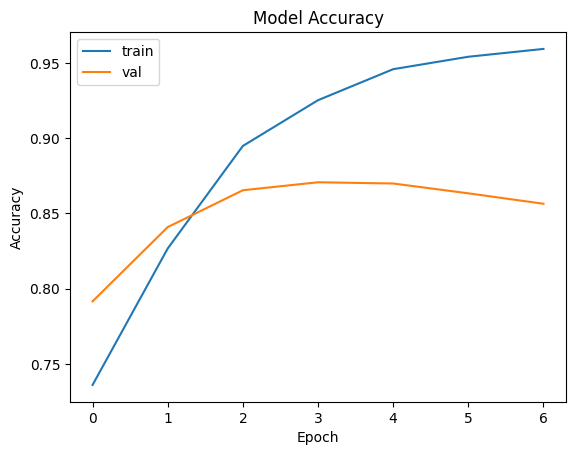

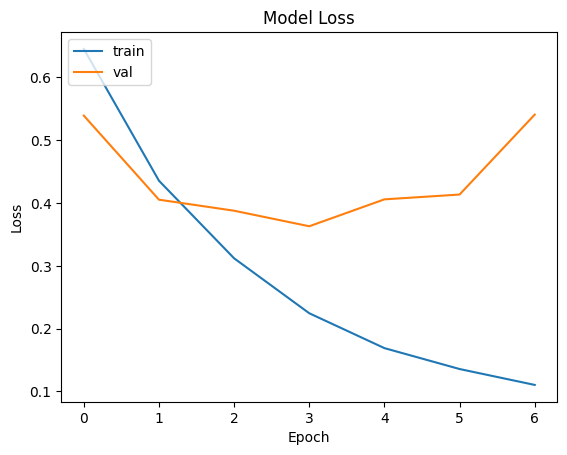

In [61]:
# Get the training history
history = model.history

# Plot the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [62]:
# classification report

from sklearn.metrics import classification_report


class_report = classification_report(y_test_e100_8020.argmax(axis=1), model.predict(X_test_e100_8020).argmax(axis=1), target_names=['negative', 'neutral', 'positive'])
print(class_report) 

77/77 [==============================] - 3s 28ms/step
              precision    recall  f1-score   support

    negative       0.87      0.76      0.81       806
     neutral       0.78      0.67      0.72       251
    positive       0.86      0.95      0.90      1395

    accuracy                           0.86      2452
   macro avg       0.84      0.79      0.81      2452
weighted avg       0.86      0.86      0.85      2452

